In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


/user/georg.eckardt/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


13


(-0.5, 127.5, 127.5, -0.5)

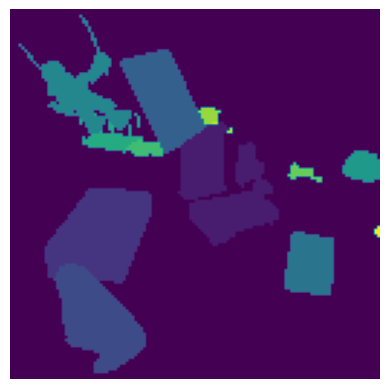

In [3]:
segmentation = np.load('data/MOVIE/segmentations/'+str(0)+'.npy')
print(segmentation[0].max())
plt.imshow(segmentation[0])
plt.axis("off")

(-0.5, 127.5, 127.5, -0.5)

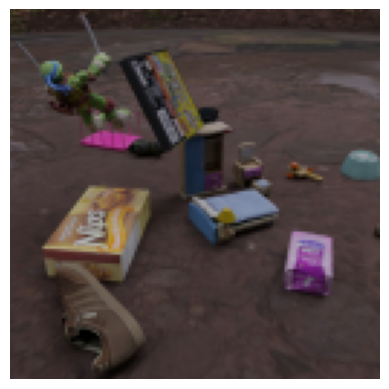

In [4]:
image = np.load('data/MOVIE/videos/'+str(0)+'.npy')
plt.imshow(image[0])
plt.axis("off")

In [5]:
number_of_videos = 50
extracted_features = 15


In [6]:
model_type = "vit_b"
sam_checkpoint = "model/"+model_type+".pth"

torch.cuda.set_device(1)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

In [7]:
def unify_masks(masks):
    uni = np.full(masks[0].shape, False)
    
    for x in masks:
        uni = np.logical_or(uni, x)
    
    return uni

def calc_iou(uni, an):
    uni = uni.squeeze()
    an = an.squeeze()

    intersection = np.logical_and(uni, an)
    union = np.logical_or(uni,an)
    
    return np.sum(intersection)/np.sum(union)

In [8]:
import cv2

save_im = 0
save_seg = 0
number_of_videos = 10
for extracted_features in range(31,32):
    iou_av = 0
    for i in range(number_of_videos):
        image = np.load('data/MOVIE/videos/'+str(i)+'.npy')
        segmentation = np.load('data/MOVIE/segmentations/'+str(i)+'.npy')

        frameSize = (image.shape[1],image.shape[2])

        im = image[0]
        seg = segmentation[0]

        masks = mask_generator.generate(im.copy())
        print(len(masks))

        for j, mask in enumerate(masks):
            mask = mask["segmentation"]
            

        extracted_masks = []
        for j,x in enumerate(masks):
            extracted_masks.append(x)
            if j == extracted_features:
                break

        seg_mask = []
        full_mask = []
        for x in extracted_masks:
            seg_mask.append(x["segmentation"])
            full_mask.append(x)
        
        uni = unify_masks(seg_mask)

        iou_av += calc_iou(uni,seg.squeeze())
        break
    print(str(extracted_features) +" : "+str(iou_av/(i+1)))

68
31 : 0.623520427644139


In [9]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import pipeline
from PIL import Image
import scipy

model_type = "vit_b"
sam_checkpoint = "model/"+model_type+".pth"

torch.cuda.set_device(1)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

# Depth Models
# Load Depth Model
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)

In [10]:
def bw_frame(frame):
    return (frame[...,0] + frame[...,1] + frame[...,2])/3

def three_dim(x):
    return np.stack( ( x.copy()*234, x.copy()*345, x.copy()*567 ), 2).astype(np.uint8)

def three_dim_bw(x):
    return np.stack( ( x.copy()*255, x.copy()*255, x.copy()*255 ), 2).astype(np.uint8)   

def extract_masks(masks, features):
    extracted_masks = []
    for j,x in enumerate(masks):
        extracted_masks.append(x["segmentation"])
        if j == features:
            break
    return extracted_masks

def mask_depth(masks, depth):
    mean_mask_depth = []

    for mask in masks:
        area = (mask == 1).sum()
        mean_mask_depth.append( ( depth * mask ).sum() / area )
    return np.array(mean_mask_depth)

def background_removal(masks, depths, threshhold_depth):

    mean = depths.mean()
    foreground_masks = []
    probabilty = []
    
    for i,x in enumerate(depths):
        prob = scipy.stats.norm(mean, 0.2).pdf(x)
        
        if  prob > threshhold_depth:
            foreground_masks.append(masks[i])
        
        probabilty.append((prob,i))
        
            
    return foreground_masks, probabilty

def unify_masks(masks):
    uni = np.full(masks[0].shape, False)
    
    for x in masks:
        uni = np.logical_or(uni, x)
    
    return uni

def calc_iou(uni, an):
    uni = uni.squeeze()
    an = an.squeeze()

    intersection = np.logical_and(uni, an)
    union = np.logical_or(uni,an)
    
    return np.sum(intersection)/np.sum(union)

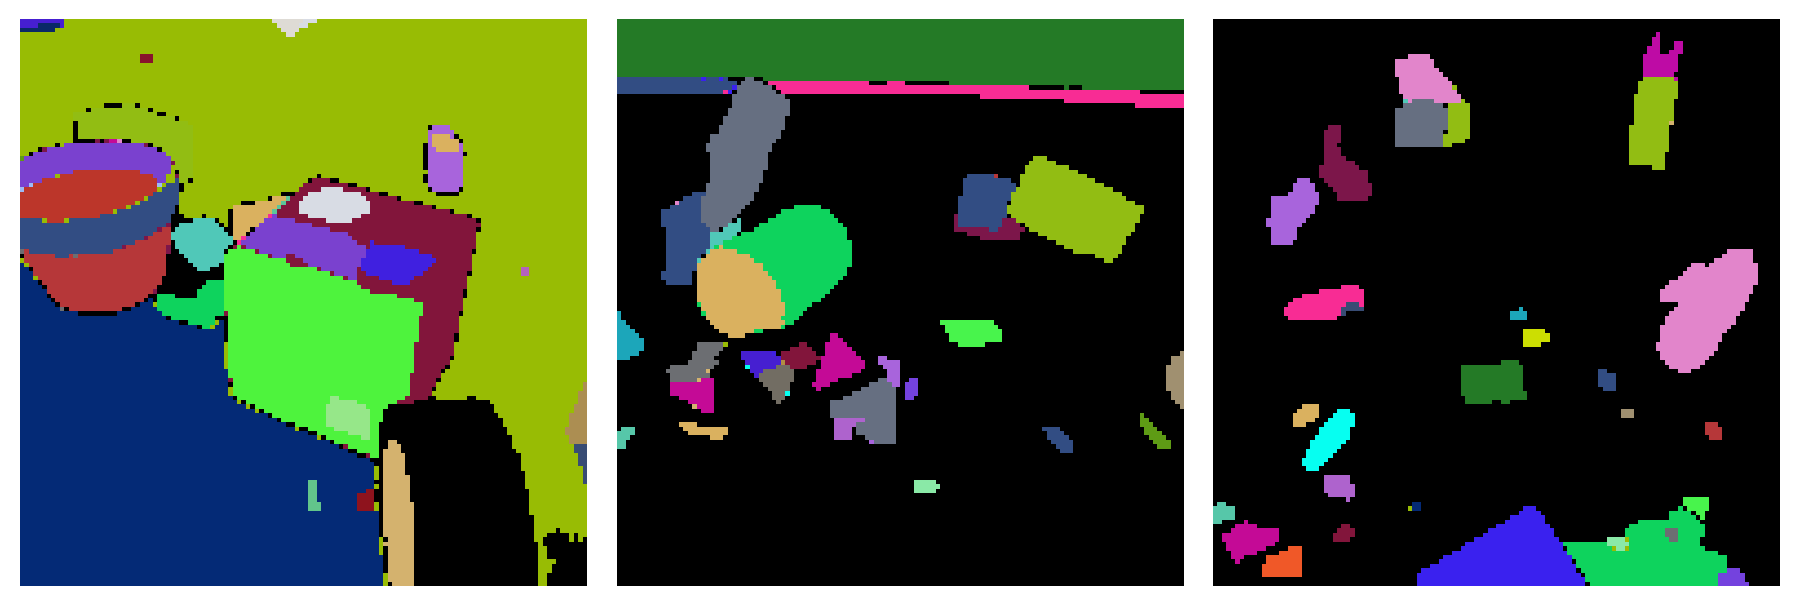

In [25]:
number_of_extracted_masks = 31
fig = plt.figure(figsize=(9.1, 7), dpi=200)

for j,i in enumerate((247, 184, 137)):
    fig.add_subplot(1,3,j+1)
    image = np.load('data/MOVIE/videos/'+str(i)+'.npy')
    segmentation = np.load('data/MOVIE/segmentations/'+str(i)+'.npy')

    j = 0
    im = image[0]

    bw_image = bw_frame(im.copy())

    depth_vals = np.array(pipe(Image.fromarray(bw_image.copy()))["depth"])
    depth_vals = depth_vals / depth_vals.max()

    masks = mask_generator.generate(im.copy())

    masks = extract_masks(masks, number_of_extracted_masks)

    mask_depths = mask_depth(masks, depth_vals) 

    foreground, probabilty = background_removal(masks, mask_depths, 0)

    sh = foreground[0].shape
    uni = np.zeros((sh[0], sh[1]))

    for i in range(1,len(foreground)):
        uni += (foreground[i].copy()*(i+1)).astype(np.int64)
    
    uni = three_dim(uni)

    plt.imshow(uni)
    plt.axis("off")

fig.tight_layout()
plt.savefig('download.jpg', bbox_inches='tight')